In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

## Cold dark matter

### To generate realizations with pyHalo you have to supply a number of keyword arguments to specify mass definitions, lens/source redshift, etc. This is made somewhat easier through the preset models, which provide functionality that one can immediately start using. 

### If you look inside the documentation in the preset_models file in pyHalo, you'll find additional details. We'll start with the most straightforward example: a CDM realization of subhalos and field halos along the line of sight:

Help on function CDM in module pyHalo.preset_models:

CDM(z_lens, z_source, sigma_sub=0.025, shmf_log_slope=-1.9, cone_opening_angle_arcsec=6.0, log_mlow=6, log_mhigh=10, LOS_normalization=1.0, log_m_host=13.3, r_tidal='0.25Rs', mass_definition='TNFW', **kwargs_other)
    This specifies the keywords for a CDM halo mass function model with a subhalo mass function described by a power law
    and a line of sight halo mass function described by Sheth-Tormen.
    
    The subhalo mass function is parameterized as
    d^N / dmdA = shmf_norm / m0 * (m/m0)^power_law_index * F(M_host, z)
    
    with a pivot mass m0=10^8. In this parameterization, shmf_norm has units of 1/area, or kpc^-2. CDM prediction is
    something like 0.01 - 0.05, but this depends on the efficiency of stripping and what objects around the host
    halo you consider a subhalos (are splashback halos subhalos?).
    
    The function F(M_host, z) factors the evolution of the projected number density of subhalos with host 

Text(0,0.5,'n(M)')

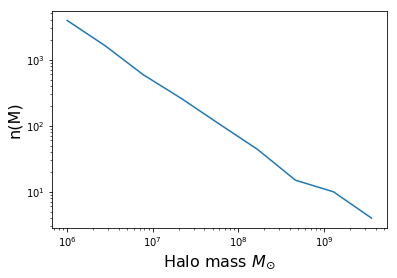

In [2]:
from pyHalo.preset_models import CDM
help(CDM)
zlens, zsource = 0.5, 2.5
realizationCDM = CDM(zlens, zsource)
print('realization contains '+str(len(realizationCDM.halos))+' halos.')
halo_masses = [halo.mass for halo in realizationCDM.halos]
N, m = np.histogram(halo_masses, bins=np.logspace(6, 10, 10))

plt.loglog(m[0:-1], N)
plt.xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
plt.ylabel('n(M)', fontsize=16)

## pyhalo is designed to be used with the software lenstronomy (https://github.com/sibirrer/lenstronomy)
## In one step, you can go from a pyhalo realization to an instance of LensModel

In [3]:
lens_model_list, lens_redshift_array, kwargs_halos, _ = realizationCDM.lensing_quantities()
# you can ignore the last argument unless you're using a profile with numerically-computed deflection angles

from lenstronomy.LensModel.lens_model import LensModel
# You should use the same astropy class created in pyhalo to do lensing computations
astropy_instance = realizationCDM.astropy_instance
lens_model_halos_only = LensModel(lens_model_list, zlens, zsource, lens_redshift_array, cosmo=astropy_instance, multi_plane=True)

## You can then look at the multi-plane convergence from subhalos only...

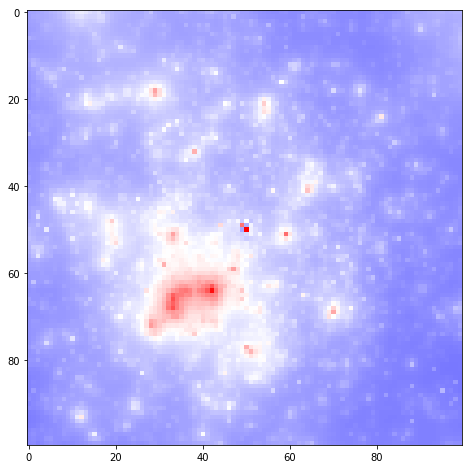

In [4]:
npix = 100 
_x = _y = np.linspace(-1.5, 1.5, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa_subs = lens_model_halos_only.kappa(xx.ravel(), yy.ravel(), kwargs_halos).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa_subs, vmin=-0.1, vmax=0.1, cmap='bwr')

### ... and the nonlinear effects that arise when the deflection angles from subhalos couple to those of a massive deflector. The code automatically generates negative convergence sheets that subtract off the mean mass you've rendered in halos, which is why some ares will appear underdense (blue) relative to the mean matter density, while other area (halos) are overdense.

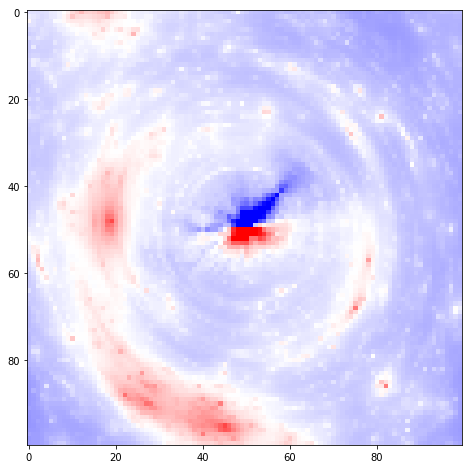

In [5]:
# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.04, 'gamma2': 0.09}]

lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_list_full = lens_model_list_macro + lens_model_list
lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
kwargs_lens_full = kwargs_macromodel + kwargs_halos

lens_model_full = LensModel(lens_model_list_full, zlens, zsource, lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True)
lens_model_macro = LensModel(lens_model_list_macro)

kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
kappa_subs_nonlinear = kappa_full - kappa_macro
plt.imshow(kappa_subs_nonlinear, vmin=-0.1, vmax=0.1, cmap='bwr')

# Warm dark matter

### You can just as easily generate realizations of warm dark matter halos using the preset model WDMLovell2020. As you can probably surmise from the title, this is the parameterization of the halo mass function presented in Lovell 2020 (https://arxiv.org/pdf/2003.01125.pdf). The documentation in the preset_models gives additional details

Help on function WDMLovell2020 in module pyHalo.preset_models:

WDMLovell2020(z_lens, z_source, log_mc, log_mlow=6.0, log_mhigh=10.0, a_wdm_los=2.3, b_wdm_los=0.8, c_wdm_los=-1.0, a_wdm_sub=4.2, b_wdm_sub=2.5, c_wdm_sub=-0.2, c_scale=60.0, c_power=-0.17, cone_opening_angle=6.0, sigma_sub=0.025, LOS_normalization=1.0, log_m_host=13.3, power_law_index=-1.9, r_tidal='0.25Rs', **kwargs_other)
    This specifies the keywords for the Warm Dark Matter (WDM) halo mass function model presented by Lovell 2020
    (https://arxiv.org/pdf/2003.01125.pdf)
    
    The differential halo mass function is described by four parameters:
    1) log_mc - the log10 value of the half-mode mass, or the scale where the WDM mass function begins to deviate from CDM
    2) a_wdm - scale factor for the characteristic mass scale (see below)
    3) b_wdm - modifies the logarithmic slope of the WDM mass function (see below)
    4) c_wdm - modifies the logarithmic slope of the WDM mass function (see below)
    
    Th

Text(0,0.5,'n(M)')

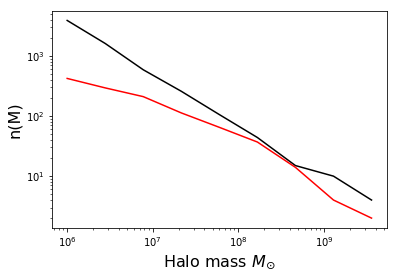

In [6]:
from pyHalo.preset_models import WDMLovell2020
help(WDMLovell2020)
log10_half_mode_mass = 7.2
realizationWDM = WDMLovell2020(zlens, zsource, log10_half_mode_mass)

print('realization contains '+str(len(realizationWDM.halos))+' halos.')
halo_masses = [halo.mass for halo in realizationWDM.halos]
Nwdm, mwdm = np.histogram(halo_masses, bins=np.logspace(6, 10, 10))

plt.loglog(m[0:-1], N, color='k')
plt.loglog(mwdm[0:-1], Nwdm, color='r')
plt.xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
plt.ylabel('n(M)', fontsize=16)

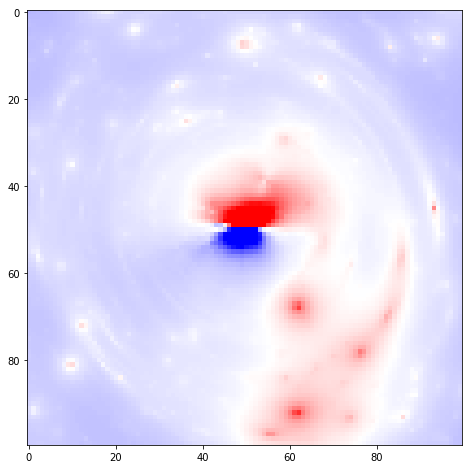

In [7]:
lens_model_list_WDM, lens_redshift_array_WDM, kwargs_halos_WDM, _ = realizationWDM.lensing_quantities()

lens_model_list_full_WDM = lens_model_list_macro + lens_model_list_WDM
lens_redshift_list_full_WDM = [zlens, zlens] + list(lens_redshift_array_WDM)
kwargs_lens_full_WDM = kwargs_macromodel + kwargs_halos_WDM

lens_model_full_WDM = LensModel(lens_model_list_full_WDM, zlens, zsource, lens_redshift_list_full_WDM, 
                                cosmo=astropy_instance, multi_plane=True)

kappa_full_WDM = lens_model_full_WDM.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full_WDM).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa_full_WDM - kappa_macro, vmin=-0.1, vmax=0.1, cmap='bwr')